In [1]:
import glob
import os
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.ops import masks_to_boxes
from torchvision.io import read_image
from prettytable import PrettyTable
from segment_anything import sam_model_registry
from torch.nn.functional import threshold, normalize
from segment_anything.utils.transforms import ResizeLongestSide

NUM_VIEWS_PER_SCENE = 6
TOD_filepath = 'C:/dataset/TOD/training_set/'

# Utils Functions
def get_bounding_boxes(mask):
    obj_ids = torch.unique(mask)
    obj_ids = obj_ids[1:]
    masks = mask == obj_ids[:, None, None]
    boxes = masks_to_boxes(masks).detach().numpy()
    if boxes.all()==None:
        boxes=np.array([])
    return boxes

def array_to_tensor(array):
    """ Converts a numpy.ndarray (N x H x W x C) to a torch.FloatTensor of shape (N x C x H x W)
        OR
        converts a nump.ndarray (H x W x C) to a torch.FloatTensor of shape (C x H x W)
    """
    if array.ndim == 4: # NHWC
        tensor = torch.from_numpy(array).permute(0,3,1,2).float()
    elif array.ndim == 3: # HWC
        tensor = torch.from_numpy(array).permute(2,0,1).float()
    else: # everything else
        tensor = torch.from_numpy(array).float()

    return tensor


# Visualization & Ploting Functions
def visualize_segmentation(im, masks, nc=None):
    """ Visualize segmentations nicely. Based on code from:
        https://github.com/roytseng-tw/Detectron.pytorch/blob/master/lib/utils/vis.py

        @param im: a [H x W x 3] RGB image. numpy array of dtype np.uint8
        @param masks: a [H x W] numpy array of dtype np.uint8 with values in {0, ..., nc-1}
        @param nc: total number of colors. If None, this will be inferred by masks

        @return: a [H x W x 3] numpy array of dtype np.uint8
    """ 
    masks = masks.astype(int)
    im = im.copy()

    # Generate color mask
    if nc is None:
        NUM_COLORS = masks.max() + 1
    else:
        NUM_COLORS = nc

    cm = plt.get_cmap('gist_rainbow')
    colors = [cm(1. * i/NUM_COLORS) for i in range(NUM_COLORS)]

    # Mask
    imgMask = np.zeros(im.shape)


    # Draw color masks
    for i in np.unique(masks):
        if i == 0: # background
            continue

        # Get the color mask
        color_mask = np.array(colors[i][:3])
        w_ratio = .4
        for c in range(3):
            color_mask[c] = color_mask[c] * (1 - w_ratio) + w_ratio
        e = (masks == i)

        # Add to the mask
        imgMask[e] = color_mask

    # Add the mask to the image
    imgMask = (imgMask * 255).round().astype(np.uint8)
    im = cv2.addWeighted(im, 0.5, imgMask, 0.5, 0.0)


    # Draw mask contours
    for i in np.unique(masks):
        if i == 0: # background
            continue

        # Get the color mask
        color_mask = np.array(colors[i][:3])
        w_ratio = .4
        for c in range(3):
            color_mask[c] = color_mask[c] * (1 - w_ratio) + w_ratio
        e = (masks == i)

        # Find contours
        contour, hier = cv2.findContours(
            e.astype(np.uint8).copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)

        # Plot the nice outline
        for c in contour:
            cv2.drawContours(im, contour, -1, (255,255,255), 2)

    return im

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

# # Ref: https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

def show_bbox_and_mask(rgb_img, bbox, mask_img):
    seg_img=visualize_segmentation(rgb_img,mask_img)
    fig = plt.figure(figsize=(10, 10)) 
    
    fig.add_subplot(1, 3, 1) 
    plt.imshow(rgb_img)
    for box in bbox:
        show_box(box, plt.gca())
    plt.axis('on')
    plt.title("BBOX")

    fig.add_subplot(1, 3, 2) 
    plt.imshow(mask_img)
    plt.axis('on')
    plt.title("MASK")

    fig.add_subplot(1, 3, 3) 
    plt.imshow(seg_img)
    plt.axis('on')
    plt.title("Segmentation")
    plt.show()

c:\Users\divya\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# https://github.com/bowang-lab/MedSAM/blob/66cf4799a9ab9a8e08428a5087e73fc21b2b61cd/finetune_and_inference_tutorial_2D_dataset.ipynb
checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda" if torch.cuda.is_available() else "cpu"
model_save_path = "model"

sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to(device)
count_parameters(sam_model)
sam_model.train()
for name, param in sam_model.named_parameters():
  if name.startswith("image_encoder") or name.startswith('mask_decoder'):
    param.requires_grad_(False)

+-----------------------------------------------------------------------------+------------+
|                                   Modules                                   | Parameters |
+-----------------------------------------------------------------------------+------------+
|                           image_encoder.pos_embed                           |  5242880   |
|                    image_encoder.patch_embed.proj.weight                    |   983040   |
|                     image_encoder.patch_embed.proj.bias                     |    1280    |
|                     image_encoder.blocks.0.norm1.weight                     |    1280    |
|                      image_encoder.blocks.0.norm1.bias                      |    1280    |
|                    image_encoder.blocks.0.attn.rel_pos_h                    |    2160    |
|                    image_encoder.blocks.0.attn.rel_pos_w                    |    2160    |
|                    image_encoder.blocks.0.attn.qkv.weight           

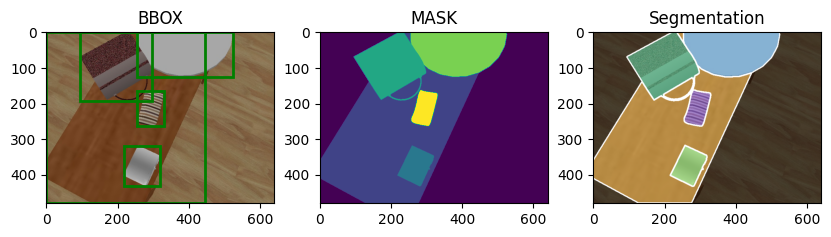

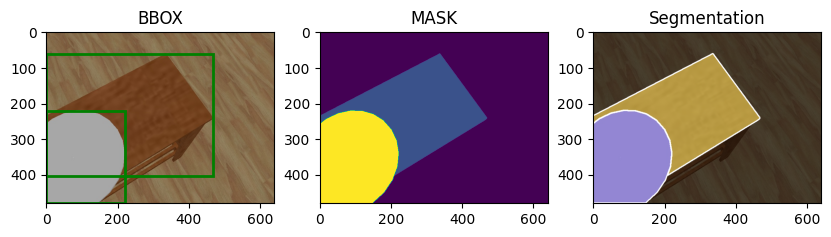

In [3]:
scene_dirs=sorted(glob.glob(TOD_filepath + '*/'))
start_idx=16
end_idx=18 
for idx in range(start_idx,end_idx):
    # Get scene directory
    scene_idx = idx // NUM_VIEWS_PER_SCENE
    scene_dir = scene_dirs[scene_idx]

    # Get view number
    view_num = (idx % NUM_VIEWS_PER_SCENE)+1
    
    # RGB image
    rgb_img_filename = scene_dir + f"rgb_{view_num:05d}.jpeg"
    rgb_img = cv2.cvtColor(cv2.imread(rgb_img_filename), cv2.COLOR_BGR2RGB) # (480, 640, 3)

    # Mask
    mask_filename = scene_dir + f"segmentation_{view_num:05d}.png"
    im = Image.open(mask_filename)
    gt_mask_img = np.array(im) # (480, 640) 

    # Bounding Box
    bbox_points = get_bounding_boxes(read_image(mask_filename)) # Shape: (N, 4) xmin, ymin, xmax, ymax
    # print(bbox_points)
    show_bbox_and_mask(rgb_img, bbox_points,gt_mask_img)

In [4]:
# scene_dirs=sorted(glob.glob(TOD_filepath + '*/'))

# for idx in range(6):
#     # Get scene directory
#     scene_idx = idx // NUM_VIEWS_PER_SCENE
#     scene_dir = scene_dirs[scene_idx]

#     # Get view number
#     view_num = (idx % NUM_VIEWS_PER_SCENE)+1
    
#     # RGB image
#     rgb_img_filename = scene_dir + f"rgb_{view_num:05d}.jpeg"
#     image = cv2.cvtColor(cv2.imread(rgb_img_filename), cv2.COLOR_BGR2RGB) # (480, 640, 3)
#     image_size=image.shape[:2] # (480. 640)

#     # Mask
#     mask_filename = scene_dir + f"segmentation_{view_num:05d}.png"
#     im = Image.open(mask_filename)
#     mask = np.array(im) # (480, 640) 

#     # Bounding Box
#     bboxes = torch.tensor(get_bounding_boxes(read_image(mask_filename))) # Shape: (*, 4) xmin, ymin, xmax, ymax

#     # Transform boxes to the proper input format
#     sam_transformations = ResizeLongestSide(sam_model.image_encoder.img_size)
#     transform_image = sam_transformations.apply_image(image)
#     transform_image = torch.as_tensor(transform_image)                                       # (768, 1024, 3)
#     transform_image = transform_image.permute(2, 0, 1).contiguous()                          # (3, 768, 1024)
#     transform_image_size=transform_image.shape[:2]                                           # (768, 1024)
#     transform_boxes = sam_transformations.apply_boxes_torch(bboxes, image_size)              # (*, 4) but scaled to new img size
#     # print(f"{bboxes=}")
#     # print(f"{transform_boxes=}")
#     print(f"{transform_image.shape=}, {mask.shape=}, {transform_boxes.shape=}")
#     print("----------------------------------------------------")

In [5]:
def collate_fn(batch):
    return tuple(zip(*batch))

def worker_init_fn(worker_id):
    """ Use this to bypass issue with PyTorch dataloaders using deterministic RNG for Numpy
        https://github.com/pytorch/pytorch/issues/5059
    """
    np.random.seed(np.random.get_state()[1][0] + worker_id)

class Tabletop_Object_Dataset(Dataset):
    """ Data loader for Tabletop Object Dataset
    """
    def __init__(self, base_dir, no):
        self.base_dir = base_dir
        # Get a list of all scenes (only 10 folders for now)
        self.scene_dirs = sorted(glob.glob(self.base_dir + '*/'))[:no]

    def __len__(self):
        return len(self.scene_dirs) * NUM_VIEWS_PER_SCENE

    def __getitem__(self, idx):

        cv2.setNumThreads(0) # some hack to make sure pyTorch doesn't deadlock. Found at https://github.com/pytorch/pytorch/issues/1355. Seems to work for me
    
        # Get scene directory
        scene_idx = idx // NUM_VIEWS_PER_SCENE
        scene_dir = self.scene_dirs[scene_idx]

        # Get view number
        view_num = (idx % NUM_VIEWS_PER_SCENE)+1
        
        # RGB image
        rgb_img_filename = scene_dir + f"rgb_{view_num:05d}.jpeg"
        image = cv2.cvtColor(cv2.imread(rgb_img_filename), cv2.COLOR_BGR2RGB) # (480, 640, 3)
        image_size=image.shape[:2] # (480, 640)

        # Mask
        mask_filename = scene_dir + f"segmentation_{view_num:05d}.png"
        im = Image.open(mask_filename)
        mask = np.array(im) # (480, 640) 

        # Bounding Box
        bboxes = torch.tensor(get_bounding_boxes(read_image(mask_filename))) # Shape: (*, 4) xmin, ymin, xmax, ymax

        # Transform input image to the proper input format and size
        sam_transformations = ResizeLongestSide(sam_model.image_encoder.img_size)
        transform_image = sam_transformations.apply_image(image)
        transform_image = torch.as_tensor(transform_image)                                       # (768, 1024, 3)
        transform_image = transform_image.permute(2, 0, 1).contiguous()                          # (3, 768, 1024)
        # transform_image_size=transform_image.shape[1:]                                           # (768, 1024)
        
        # Transform boxes to proper input format
        transform_boxes = sam_transformations.apply_boxes_torch(bboxes, image_size)              # (*, 4) but scaled to new img size   

        # Seperate Masks 
        num_objects=bboxes.shape[0] 
        torch_mask = torch.tensor(np.array([mask]))
        gtmask = torch.zeros((num_objects, 480, 640), dtype=torch.float32)                    # (*, 480, 640)
        for obj in range(1, num_objects + 1):
            gtmask[obj - 1] = (torch_mask == obj).float()
        return transform_image, gtmask, transform_boxes
    
dataset = Tabletop_Object_Dataset(TOD_filepath, 5)
# dl = DataLoader(dataset=dataset, batch_size=1, shuffle=True, collate_fn=collate_fn, worker_init_fn=worker_init_fn)
# dataset = Tabletop_Object_Dataset(TOD_filepath, get_transform(train=True))
dl = DataLoader(dataset=dataset, batch_size=1, shuffle=True, worker_init_fn=worker_init_fn)

dataset.__len__(), len(dl)

(30, 30)

In [6]:
count_parameters(sam_model)
# Adam(sam_model.prompt_encoder.parameters(), lr=1e-5, weight_decay=0)
optimizer = torch.optim.Adam(sam_model.prompt_encoder.parameters(), lr=1e-5) # Default lr = 0.001
criterion_mse = torch.nn.MSELoss()
# criterion_bce = torch.nn.BCELoss()

+------------------------------------------+------------+
|                 Modules                  | Parameters |
+------------------------------------------+------------+
| prompt_encoder.point_embeddings.0.weight |    256     |
| prompt_encoder.point_embeddings.1.weight |    256     |
| prompt_encoder.point_embeddings.2.weight |    256     |
| prompt_encoder.point_embeddings.3.weight |    256     |
| prompt_encoder.not_a_point_embed.weight  |    256     |
| prompt_encoder.mask_downscaling.0.weight |     16     |
|  prompt_encoder.mask_downscaling.0.bias  |     4      |
| prompt_encoder.mask_downscaling.1.weight |     4      |
|  prompt_encoder.mask_downscaling.1.bias  |     4      |
| prompt_encoder.mask_downscaling.3.weight |    256     |
|  prompt_encoder.mask_downscaling.3.bias  |     16     |
| prompt_encoder.mask_downscaling.4.weight |     16     |
|  prompt_encoder.mask_downscaling.4.bias  |     16     |
| prompt_encoder.mask_downscaling.6.weight |    4096    |
|  prompt_enco

In [7]:
num_epochs=5
losses=[]

for epoch in range(num_epochs):
    epoch_loss=0
    for step, (image, mask, box) in enumerate(tqdm(dl, desc=f"EPOCH {epoch}: ")):
        
        # print(type(image),type(mask),type(box))
        # print(f"{image.shape=},{mask.permute(1, 0, 2, 3).shape=},{box[0].shape=}")
        
        input_image = sam_model.preprocess(image.to(device))                                                    # Shape: (1, 3, 1024, 1024)
        image_embedding = sam_model.image_encoder(input_image)                                                  # Shape: (1, 256, 64, 64)  
        
        # print(f"{image_embedding.shape=}")
        sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
            points=None,
            boxes=box[0].to(device),
            masks=None,
        )

        # print(f"{sparse_embeddings.shape=}, {dense_embeddings.shape=}")
        low_res_masks, iou_predictions = sam_model.mask_decoder(
            image_embeddings=image_embedding,                                                                   # Shape: (1, 256, 64, 64)
            image_pe=sam_model.prompt_encoder.get_dense_pe(),                                                   # Shape: (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings,                                                         # Shape: (*, 2, 256) 
            dense_prompt_embeddings=dense_embeddings,                                                           # Shape: (*, 256, 64, 64)
            multimask_output=False,
        ) 
        
        # print(f"{low_res_masks.shape=}, {iou_predictions.shape=}") # 
        upscaled_masks = sam_model.postprocess_masks(low_res_masks, (1024, 1024), (480, 640)).to(device)
        binary_mask = normalize(threshold(upscaled_masks, 0.0, 0))                                              # Shape: (*, 1, 480, 640)
        # print(f"{binary_mask.shape=}")
        mask = mask.permute(1, 0, 2, 3)
        # print(mask.permute(1, 0, 2, 3).shape, binary_mask.shape)

        loss = criterion_mse(binary_mask.to(float), mask.to(float).to(device))
        # loss2 = criterion_bce(binary_mask.to(float), mask.to(float).to(device))
        # print(f"{loss1.item()=}\t{loss2.item()=}")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
            
    # epoch_loss /= step
    losses.append(epoch_loss)
    print(f'EPOCH: {epoch}, Loss: {epoch_loss}')
    # save the latest model checkpoint
    torch.save(sam_model.state_dict(), os.path.join('model/sam_model_latest.pth'))

Epoch 0: 100%|██████████| 30/30 [01:15<00:00,  2.50s/it]


EPOCH: 0, Loss: 1.6968857241030098


Epoch 1: 100%|██████████| 30/30 [01:11<00:00,  2.37s/it]


EPOCH: 1, Loss: 1.6969066116898146


Epoch 2: 100%|██████████| 30/30 [01:10<00:00,  2.36s/it]


EPOCH: 2, Loss: 1.6968963306568288


Epoch 3: 100%|██████████| 30/30 [01:11<00:00,  2.38s/it]


EPOCH: 3, Loss: 1.6968746202256941


Epoch 4: 100%|██████████| 30/30 [01:11<00:00,  2.38s/it]


EPOCH: 4, Loss: 1.6968945312500001
